In [1]:
import wfdb
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import ast
import os
import json

In [2]:
# imports for filtering

from scipy.signal import butter, lfilter, iirnotch, filtfilt
from scipy.signal import find_peaks

### Code for reading a single signal:

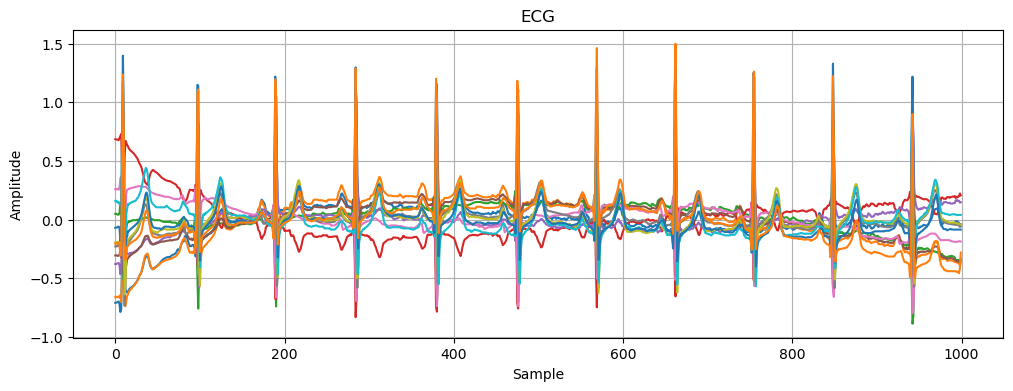

In [3]:
# Specify the path to your WFDB signal file (e.g., '01000_lr.dat')
signal_file = '01000_lr'

# Use wfdb.rdrecord() to read the signal file
record = wfdb.rdrecord(signal_file)

# Access the signal data and metadata
signal_data = record.p_signal  # NumPy array containing signal data
signal_metadata = record.__dict__  # Dictionary containing metadata

# You can access various metadata properties like sampling frequency, units, etc.
fs = record.fs  # Sampling frequency

# Visualize the signal
plt.figure(figsize=(12, 4))
plt.plot(signal_data)
plt.title('ECG')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [4]:
signal_data.shape # 12 different signals from each lead and each signal has 1000 samples. 

(1000, 12)

### Filtering of a single signal
#### - Şimal'in eklediği kısım

RR Intervals:
[0.89 0.92 0.94 0.96 0.96 0.93 0.93 0.93 0.93 0.94]
Heart Rates:
[67.41573034 65.2173913  63.82978723 62.5        62.5        64.51612903
 64.51612903 64.51612903 64.51612903 63.82978723]
Average Heart Rate: 64.33572122385439 BPM


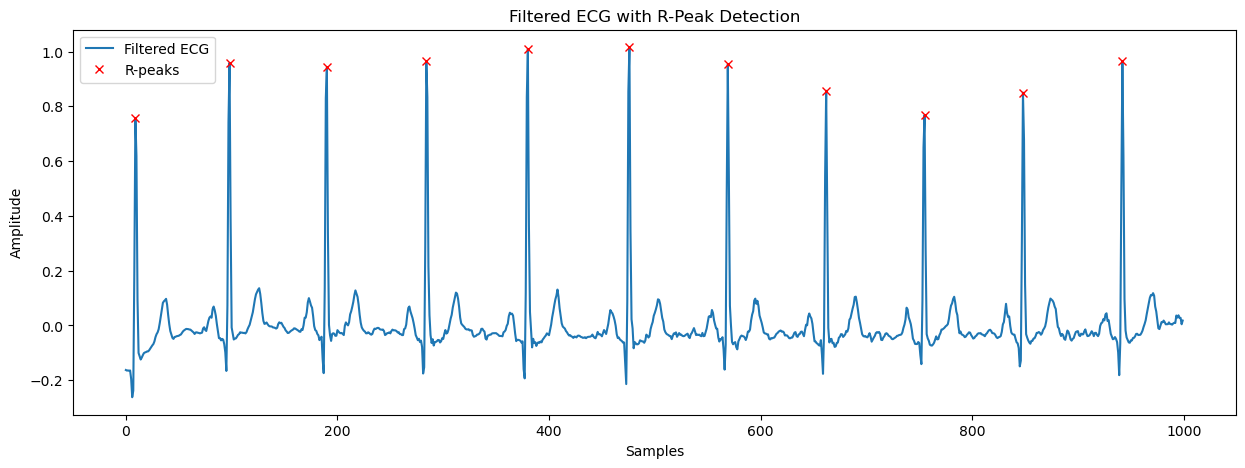

In [4]:
# Example: Filtering the ECG signal (Lead I)
ecg_lead = signal_data[:, 0]  # Assuming Lead I is the first column

# High-pass filter to remove baseline wander
b, a = butter(1, 0.5/(0.5*fs), btype='highpass')
filtered_ecg = filtfilt(b, a, ecg_lead)

# R-peak detection
r_peaks, _ = find_peaks(filtered_ecg, height=np.max(filtered_ecg)*0.5, distance=fs*0.6)
rr_intervals = np.diff(r_peaks) / fs  # dividing by sampling frequency to get time in seconds
print("RR Intervals:")
print(rr_intervals)

heart_rate = 60 / rr_intervals  # BPM
print("Heart Rates:")
print(heart_rate)

average_heart_rate = np.mean(heart_rate)

print(f"Average Heart Rate: {average_heart_rate} BPM")
# Visualize filtered signal with R-peaks
plt.figure(figsize=(15, 5))
plt.plot(filtered_ecg, label='Filtered ECG')
plt.plot(r_peaks, filtered_ecg[r_peaks], 'rx', label='R-peaks')
plt.title('Filtered ECG with R-Peak Detection')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

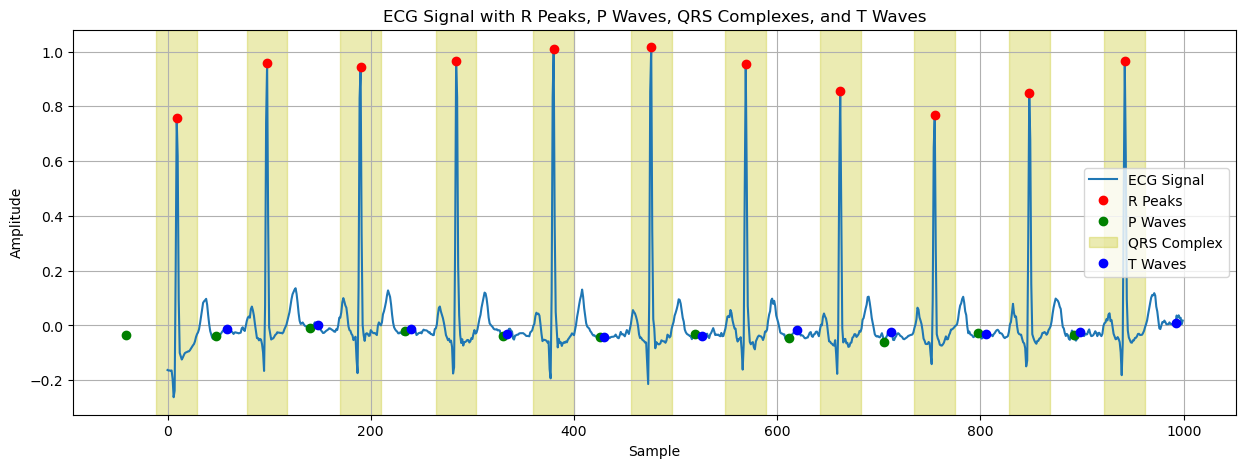

In [5]:
# Sample ECG data - replace with your actual data

# Sample indices for P waves, QRS complexes, and T waves - replace with actual indices
p_waves = r_peaks - 50  # Example P wave indices
qrs_start = r_peaks - 20  # Example start of QRS complex
qrs_end = r_peaks + 20   # Example end of QRS complex
t_waves = r_peaks + 50  # Example T wave indices

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(filtered_ecg, label='ECG Signal')

# Mark R peaks
plt.plot(r_peaks, filtered_ecg[r_peaks], 'ro', label='R Peaks')

# Mark P waves
plt.plot(p_waves, filtered_ecg[p_waves], 'go', label='P Waves')

# Mark QRS complexes
for start, end in zip(qrs_start, qrs_end):
    plt.axvspan(start, end, color='y', alpha=0.3, label='QRS Complex' if start == qrs_start[0] else "")

# Mark T waves
plt.plot(t_waves, filtered_ecg[t_waves], 'bo', label='T Waves')

plt.title('ECG Signal with R Peaks, P Waves, QRS Complexes, and T Waves')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


### Code for reading multiple signals:

In [6]:
def load_raw_data(df, sampling_rate, path):
    data = []
    
    
    warning_issued = False  # flag to track if a warning has been issued
    
    if sampling_rate == 100:
        filenames = df.filename_lr
    else:
        filenames = df.filename_hr
    
    for f in filenames:
        
        # Append file extensions for both .hea and .dat files
        file_path_dat = os.path.join(path, f + '.dat')
        file_path_hea = os.path.join(path, f + '.hea')
        
        # Check if both files exist
        if os.path.exists(file_path_dat) and os.path.exists(file_path_hea):
            signal, meta = wfdb.rdsamp(os.path.join(path, f), channels=[1])
            data.append(signal)
            
        else:
            if not warning_issued:
                print("Warning: One or more files do not exist. Further missing files will not be reported.")
                warning_issued = True
    
    if not data:
        print("No valid data found.")
        return None
    
    
    data = np.array(data)
    return data

sampling_rate=100

# load and convert annotation data
Y = pd.read_csv('ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

### We need to create records100\00000\ folders in order to read multiple signals using Y 
#### - check filename_lr column of Y

In [7]:
# Y dataframe stores the address of each signal in the filename_lr column but we need to change the format of the address (for Windows)
Y['filename_lr'] = Y['filename_lr'].str.replace('/', '\\')

### X array stores the information from multiple signals and only from the first channel (lead)

In [8]:
X = load_raw_data(Y, sampling_rate, os.getcwd())

### Finding Unique Dictionaries in the "scp_codes" column

In [22]:
Y.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object')

In [9]:
def remove_zero_values(d):
    """Remove key-value pairs with 0.0 value from a dictionary."""
    # since 0.0 likelihood is used for unknown likelihood
    return {k: v for k, v in d.items() if v != 0.0}

# apply this function to each dictionary in the column
Y['scp_codes'] = Y['scp_codes'].apply(remove_zero_values)

In [10]:
# Define the set of keys you are looking for
searched_keys = {'IMI', 'ASMI', 'ILMI', 'AMI', 'ALMI', 'LMI', 'IPLMI', 'IPMI', 'PMI'}

# Function to check if all required keys are in the dictionary
def contains_searched_keys(d):
    return any(k in d for k in searched_keys)

# Create a boolean mask
mask = Y['scp_codes'].apply(contains_searched_keys)

# Filter the DataFrame
MI_df = Y[mask]

### Filtering SCP codes that implies Myocardial Infarction:

In [11]:
scp_df = pd.read_csv('scp_statements.csv', index_col=0)

In [12]:
filter_condition = scp_df['Statement Category'] == 'Myocardial Infarction'

# Apply the filter condition to the DataFrame
scp_filtered = scp_df[filter_condition]
scp_filtered

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
IMI,inferior myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferior myocardial infarction,161.0,NaN,NaN,NaN
ASMI,anteroseptal myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anteroseptal myocardial infarction,165.0,NaN,NaN,NaN
ILMI,inferolateral myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferolateral myocardial infarction,NaN,NaN,NaN,NaN
AMI,anterior myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anterior myocardial infarction,160.0,NaN,NaN,NaN
ALMI,anterolateral myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anterolateral myocardial infarction,NaN,NaN,NaN,NaN
LMI,lateral myocardial infarction,1.0,NaN,NaN,MI,LMI,Myocardial Infarction,lateral myocardial infarction,163.0,NaN,NaN,NaN
IPLMI,inferoposterolateral myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferoposterolateral myocardial infarction,NaN,NaN,NaN,NaN
IPMI,inferoposterior myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferoposterior myocardial infarction,NaN,NaN,NaN,NaN
PMI,posterior myocardial infarction,1.0,NaN,NaN,MI,PMI,Myocardial Infarction,posterior myocardial infarction,162.0,NaN,NaN,NaN


### Filtering rows to choose the training set

In [38]:
min_age = 20
max_age = 60

age_mask = (MI_df['age'] >= min_age) & (MI_df['age'] <= max_age)
filtered_df = MI_df[age_mask]

columns_to_remove = ['baseline_drift', 'burst_noise', 'static_noise', 'electrodes_problems', 'pacemaker', 'extra_beats', 'nurse', 'site']

# remove the specified columns
filtered_df = filtered_df.drop(columns=columns_to_remove)

# boolean mask to filter the dataframe by "age", "human validation", and "device"

filtered_df = filtered_df[filtered_df.validated_by_human == True]
filtered_df = filtered_df[filtered_df.device == 'CS100    3']
strat_fold_mask = (filtered_df['strat_fold'] < 9)
filtered_df = filtered_df[strat_fold_mask]

In [15]:
filtered_df[filtered_df.sex == 1].filename_lr

ecg_id
9068     records100\09000\09068_lr
9098     records100\09000\09098_lr
13654    records100\13000\13654_lr
14803    records100\14000\14803_lr
16732    records100\16000\16732_lr
19439    records100\19000\19439_lr
19462    records100\19000\19462_lr
21682    records100\21000\21682_lr
Name: filename_lr, dtype: object

In [17]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv('scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# apply aggregate_diagnostic function to Y.scp_codes column
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

### Sağlıklı insanların Verisi
#### - bu kişilere ait dosyaları veri setinden indireceğiz.

In [34]:
norm_key = {'NORM'}

# Function to check if all required keys are in the dictionary
def contains_required_keys(d):
    return norm_key.issubset(d.keys())

# Create a boolean mask
mask = Y['scp_codes'].apply(contains_required_keys)

# Filter the DataFrame
Y_norm = Y[mask]

In [37]:
norm_age_mask = (Y_norm['age'] >= min_age) & (Y_norm['age'] <= max_age)
norm_filtered = Y_norm[norm_age_mask]

# remove the specified columns
norm_filtered = norm_filtered.drop(columns=columns_to_remove)

# boolean mask to filter the dataframe by "age", "human validation", and "device"

norm_filtered = norm_filtered[norm_filtered.validated_by_human == True]
norm_filtered = norm_filtered[norm_filtered.device == 'CS100    3']
strat_fold_mask = (norm_filtered['strat_fold'] < 9)
norm_filtered = norm_filtered[strat_fold_mask]
norm_filtered

,patient_id,age,sex,height,weight,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,
4441,12710.0,42.0,0,NaN,NaN,CS100 3,1990-07-13 13:13:32,sinusrhythmus lagetyp normal normales ekg 4.46...,{'NORM': 100.0},MID,NaN,NaN,NaN,True,True,True,7,records100\04000\04441_lr,records500/04000/04441_hr,[NORM]
5063,10927.0,52.0,0,NaN,NaN,CS100 3,1990-09-26 11:13:00,sinusrhythmus lagetyp normal normales ekg 4.46...,{'NORM': 100.0},MID,NaN,NaN,NaN,True,True,True,3,records100\05000\05063_lr,records500/05000/05063_hr,[NORM]
5250,10386.0,52.0,1,NaN,NaN,CS100 3,1990-10-26 16:46:18,sinusrhythmus linkstyp unvollstÄndiger rechtss...,"{'NORM': 80.0, 'IRBBB': 100.0}",LAD,NaN,NaN,1.0,False,True,True,4,records100\05000\05250_lr,records500/05000/05250_hr,"[NORM, CD]"
7047,12527.0,40.0,1,NaN,NaN,CS100 3,1991-09-27 07:10:35,sinusrhythmus lagetyp normal normales ekg 4.46...,{'NORM': 100.0},MID,NaN,NaN,NaN,True,True,True,5,records100\07000\07047_lr,records500/07000/07047_hr,[NORM]
7225,21424.0,54.0,1,NaN,NaN,CS100 3,1991-10-28 09:32:08,sinusrhythmus linkstyp sonst normales ekg 4.46...,{'NORM': 80.0},LAD,NaN,NaN,1.0,False,True,True,4,records100\07000\07225_lr,records500/07000/07225_hr,[NORM]
7269,17637.0,51.0,1,NaN,NaN,CS100 3,1991-11-07 17:45:53,sinusrhythmus linkstyp sonst normales ekg 4.46...,{'NORM': 50.0},LAD,NaN,NaN,NaN,True,True,True,8,records100\07000\07269_lr,records500/07000/07269_hr,[NORM]
9277,8803.0,48.0,1,NaN,NaN,CS100 3,1992-11-03 11:11:41,sinusrhythmus linkstyp sonst normales ekg 4.46...,"{'NORM': 100.0, 'LAFB': 100.0}",LAD,NaN,NaN,NaN,True,True,True,5,records100\09000\09277_lr,records500/09000/09277_hr,"[NORM, CD]"
11337,13132.0,31.0,1,NaN,NaN,CS100 3,1993-11-08 11:33:49,sinustachykardie lagetyp normal sonst normales...,{'NORM': 15.0},MID,NaN,NaN,NaN,True,True,True,4,records100\11000\11337_lr,records500/11000/11337_hr,[NORM]
13285,16628.0,56.0,0,NaN,NaN,CS100 3,1994-11-06 07:52:59,sinusrhythmus linkstyp r-s Übergang in v ablei...,"{'NORM': 100.0, 'IVCD': 100.0}",LAD,NaN,NaN,NaN,True,True,True,1,records100\13000\13285_lr,records500/13000/13285_hr,"[NORM, CD]"


### The below cell will be tested later

In [ ]:
# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass